##  This Section is for extracting data from all text files, and creating the dataset

### <u>Imports<u>

In [1]:
import numpy as np
import pandas as pd
import re
from itertools import product
from pandas import Series
from sklearn.preprocessing import MinMaxScaler

# For feature ranking 
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
import warnings; warnings.simplefilter('ignore')

### <u>Inputs<u>

In [2]:
nx = 108               #number of grids in x-direction
ny = 100               #number of grids in y-direction
nz = 63                #number of grids in z-direction
nruns = 15             #number of LHS points that is used to initially run the Eclipse
nt = nx * ny * nz
print("No. grids before filtering (for 1 run):   " + str(nt))
print("No. grids before filtering (for all run): " + str(nt*nruns))

No. grids before filtering (for 1 run):   680400
No. grids before filtering (for all run): 10206000


### <u>Functions<u>

In [3]:
# function for reading the text files and extracting the numbers
def splitter(file):

    lines = file.readlines()
    B = [x for x in lines if not x.startswith('--')]
    C = " ".join(B)
    nums = []
    #                            3*4.52          4*0       0\n    24*0.00       4.235e-10 or 4.235E-10          5e-10 or 5E-10 
    for n in re.findall(r'\d+\*\d*\.\d+|\d+\*[-+]\d+\.\d+|\d+\*\d+|[0]\|[0]\n|\d+\.\d+(?:e[+-]\d+|E[-+]\d+)?|\d+(?:e[+-]\d+|E[-+]\d+)?', C):
        split_by_ast = n.split("*")
        if len(split_by_ast) == 1:
            nums += [float(split_by_ast[0])]
        else:
            nums += [float(split_by_ast[1])] * int(split_by_ast[0])
    return nums


def repeat(x):
    A = list(np.array(x)[actives])*nruns
    B = np.array(A)
    return B

### <u>Finding the Active Grids<u>

In [4]:
a = open('C:/Users/pymnb/Downloads/VOLVE/15/features/001.soil.for.location.txt', 'r')

SOIL = np.array(splitter(a)).reshape((nt, 1), order='F')
SOIL[SOIL < 0.053] = 0

#removing a few grids where they were out of the main reservoir in VOLVE field
indices = [554377, 565177, 575977, 576085, 586777, 586885, 597577, 597685, 608377, 608485, 619177,\
619285, 629977, 630085, 640777, 640885, 651577, 651685, 662377, 662485, 673177, 673285]

SOIL[indices]=0
actives = np.where(SOIL!=0)[0]
#np.savetxt('active_cells_index', active)

#Tot_grids = len(active)*nruns

print("No. grids after filtering (for 1 run):   " + str(actives.shape[0]))
print("No. grids after filtering (for all run): " + str(actives.shape[0]*nruns))

No. grids after filtering (for 1 run):   61416
No. grids after filtering (for all run): 921240


# <u>Extraction of Parameters<u>

### i, j, k

In [5]:
T1 = sorted(list(product(range(1,nx+1), range(1,ny+1), range(1,nz+1))), key=lambda x: (x[2], x[1], x[0]))
ijk_all = [list(x) for x in T1]

ijk = repeat(ijk_all)

### x, y, z

In [6]:
# Expanding x,y,z to all gridblocks

a1 = open('C:/Users/pymnb/Downloads/VOLVE/15/features/002.xcord.txt', 'r')
b1 = open('C:/Users/pymnb/Downloads/VOLVE/15/features/003.ycord.txt', 'r')
c1 = open('C:/Users/pymnb/Downloads/VOLVE/15/features/004.zcord.txt', 'r')

xcord = np.array(list(np.array(splitter(a1))[actives])*nruns).reshape(actives.shape[0]*nruns,1)
ycord = np.array(list(np.array(splitter(b1))[actives])*nruns).reshape(actives.shape[0]*nruns,1)
zcord = np.array(list(np.array(splitter(c1))[actives])*nruns).reshape(actives.shape[0]*nruns,1)

### Grid Type

In [7]:
# injectors and producers wellpathes through grids

# For injectors
a2 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/005.IF1B_path.txt', 'r').readlines())
a3 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/005.IF4_path.txt', 'r').readlines())
a4 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/005.IF5_path.txt', 'r').readlines())

a2, a3, a4 = (re.findall(r'\d+', a2)) , (re.findall(r'\d+', a3)), (re.findall(r'\d+', a4))  # it generates a list of strings
a2, a3, a4 = list(map(int, a2)), list(map(int, a3)), list(map(int, a4))     # it generates a list of numbers
inj_path_IF1B = np.array(a2).reshape((58,3), order = 'C')
inj_path_IF4 = np.array(a3).reshape((62,3), order = 'C')
inj_path_IF5 = np.array(a4).reshape((63,3), order = 'C')
inj_path = np.concatenate([inj_path_IF1B, inj_path_IF4, inj_path_IF5], axis=0)

# For producers
b2 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/006.PF1C_path.txt', 'r').readlines())
b3 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/006.PF11B_path.txt', 'r').readlines())
b4 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/006.PF12_path.txt', 'r').readlines())
b5 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/006.PF14_path.txt', 'r').readlines())
b6 = " ".join(open('C:/Users/pymnb/Downloads/VOLVE/15/features/006.PF15C_path.txt', 'r').readlines())

b2, b3, b4, b5, b6 = (re.findall(r'\d+', b2)), (re.findall(r'\d+', b3)), (re.findall(r'\d+', b4)),\
                     (re.findall(r'\d+', b5)), (re.findall(r'\d+', b6))
b2, b3, b4, b5, b6 = list(map(int, b2)), list(map(int, b3)), list(map(int, b4)), list(map(int, b5)), list(map(int, b6))
prod_path_PF1C = np.array(b2).reshape((103,3), order = 'C')
prod_path_PF11B = np.array(b3).reshape((91,3), order = 'C')
prod_path_PF12 = np.array(b4).reshape((52,3), order = 'C')
prod_path_PF14 = np.array(b5).reshape((112,3), order = 'C')
prod_path_PF15C = np.array(b6).reshape((49,3), order = 'C')
prod_path = np.concatenate([prod_path_PF1C, prod_path_PF11B, prod_path_PF12, prod_path_PF14, prod_path_PF15C], axis=0)

df_path_PF1C, df_path_PF11B, df_path_PF12, df_path_PF14, df_path_PF15C = pd.DataFrame(prod_path_PF1C),\
                                                        pd.DataFrame(prod_path_PF11B), pd.DataFrame(prod_path_PF12),\
                                                        pd.DataFrame(prod_path_PF14), pd.DataFrame(prod_path_PF15C)
df_path_IF1B, df_path_IF4, df_path_IF5 = pd.DataFrame(inj_path_IF1B), pd.DataFrame(inj_path_IF4), pd.DataFrame(inj_path_IF5)

In [8]:
# create the column for grid type (nothing =1 , injector = 2 , producers = 3)

loc_inj  = np.argwhere((np.array(ijk_all)[actives] ==  inj_path[:, None]).all(axis=2))[:, 1]

loc_prod = np.argwhere((np.array(ijk_all)[actives] == prod_path[:, None]).all(axis=2))[:, 1]

grid_type = (np.ones((len(actives)), dtype=int)).tolist()

for i in loc_inj:
    grid_type[i] = 2

for i in loc_prod:
    grid_type[i] = 3

grid_type = np.array(list(np.array(grid_type).reshape(len(actives),1))*nruns)     # column for 15 runs

### Distance to Faults

In [9]:
# Distances of grids to the nearest fault

f = open('C:/Users/pymnb/Downloads/VOLVE/15/features/007.D_faults.txt', 'r')

D_faults = repeat(splitter(f)).reshape(actives.shape[0]*nruns,1)

### Distance to Producers/Injectors

In [10]:
# Distances of grids to the injecors and producers

D = {}
#              D0          D1            D2           D3            D4              D5           D6              D7
names1 = ['008.D_IF1B', '009.D_IF4', '010.D_IF5', '011.D_PF1C', '012.D_PF11B', '013.D_PF12', '014.D_PF14', '015.D_PF15C']

for idx,name in enumerate(names1):
    with open('C:/Users/pymnb/Downloads/VOLVE/15/features/'+name+'.txt','r') as Dis:
        D['D'+str(idx)] = np.array(splitter(Dis)).reshape((nt, 1), order='F')

# Create columns of Distances for 1 run
D_inj  = np.sort(np.concatenate([ D['D0'], D['D1'], D['D2'] ], axis=1))   
D_prod = np.sort(np.concatenate([ D['D3'], D['D4'], D['D5'], D['D6'], D['D7'] ], axis=1))

# Create columns of Distances for all run
D_prod = D_prod[:,0:3]    # choose 1st, 2nd, 3rd COWPROD
D_inj  = repeat(D_inj)
D_prod = repeat(D_prod)

### Other Static Characteristics

In [11]:
# Different static parameters

s = {}
#            s0           s1        s2         s3          s4          s5         s6          s7      
names2 = ['016.ver_H','017.str_H','018.vol','019.angle','020.NTG','021.permx','022.permy','023.permz',\
         '024.poro','025.tranx','026.trany','027.tranz']
#            s8          s9           s10         s11

for idx,name in enumerate(names2):
    with open('C:/Users/pymnb/Downloads/VOLVE/15/features/'+name+'.txt','r') as f:
        s['s'+str(idx)] = np.array(splitter(f)).reshape(nt,1)

s_features = np.concatenate([ s['s0'], s['s1'], s['s2'], s['s3'], s['s5'], s['s6'], s['s7'],\
                              s['s8'], s['s9'], s['s10'],s['s11'] ], axis=1)
s_features  = repeat(s_features)

### Initial State for Dynamic Parameters

In [12]:
# initial state of dynamic parameters
I = {}
#            I0                 I1
names3 = ['028.SO_initial', '029.P_initial']

for idx,name in enumerate(names3):
    with open('C:/Users/pymnb/Downloads/VOLVE/15/features/'+name+'.txt','r') as i:
        I['I'+str(idx)] = np.array(splitter(i)).reshape(nt,1)

ini_SO, ini_P = I['I0'], I['I1']

#ini_features = np.conI['I1']catenate([ I['I0'], I['I1']], axis=1)
ini_SO, ini_P  = repeat(ini_SO), repeat(ini_P)
ini_SO[ini_SO<0.001] = 0

### Sample Points

In [13]:
# LHS points
pf11b_rates = [68,   2142, 1956, 4964, 3336, 1434, 4118, 2812, 866,  3781, 364,  4470, 1218, 3278, 2653]
pf12_rates  = [1521, 4936, 2416, 3812, 3098, 848,  1084, 134,  4257, 2911, 423,  4558, 3407, 1970, 2091]
pf14_rates  = [2632, 1268, 4764, 4282, 882,  321,  2001, 3894, 3473, 1502, 4484, 605,  3205, 1981, 2815]
pf1c_rates  = [3665, 4450, 3134, 2601, 1688, 2305, 4915, 1308, 921,  240,  596,  4032, 3697, 1536, 2972]
pf15c_rates = [4027, 1942, 323,  3153, 4887, 1386, 2003, 3966, 2850, 777,  412,  4589, 1114, 3467, 2458]

L = len(actives)
Tot_grids = L*nruns

pf11b_rep = np.zeros((Tot_grids, 1))
pf12_rep  = np.zeros((Tot_grids, 1))
pf14_rep  = np.zeros((Tot_grids, 1))
pf1c_rep  = np.zeros((Tot_grids, 1))
pf15c_rep = np.zeros((Tot_grids, 1))

for i in range(1,nruns+1):
    pf11b_rep[len(actives)*(i-1):(len(actives)*i)+1,:]  = pf11b_rates[i-1]
    pf12_rep[len(actives)*(i-1):(len(actives)*i)+1,:]   = pf12_rates[i-1]
    pf14_rep[len(actives)*(i-1):(len(actives)*i)+1,:]   = pf14_rates[i-1]
    pf1c_rep[len(actives)*(i-1):(len(actives)*i)+1,:]   = pf1c_rates[i-1]
    pf15c_rep[len(actives)*(i-1):(len(actives)*i)+1,:]  = pf15c_rates[i-1]

### Dynamic Parameters (outputs)

In [14]:
so = open('C:/Users/pymnb/Downloads/VOLVE/15/features/030.SO.txt', 'r')
p  = open('C:/Users/pymnb/Downloads/VOLVE/15/features/031.P.txt', 'r')

so = np.array(splitter(so)).reshape((nx*ny*nz, 40, nruns), order="F")
p = np.array(splitter(p)).reshape((nx*ny*nz, 40, nruns), order="F")

Z1, Z2 = np.zeros((nt*nruns,1)), np.zeros((nt*nruns,1))

for i in range(0,40):
    H1, H2 = so[:,i,:], p[:,i,:]
    H1, H2 = H1.reshape([nt*nruns, 1], order="F"), H2.reshape([nt*nruns, 1], order="F")
    
    SOIL, P = np.concatenate([Z1, H1], axis=1), np.concatenate([Z2, H2], axis=1)
                        
    Z1, Z2 = SOIL, P

SOIL, P = SOIL[:, 1:40+1], P[:, 1:40+1]
SOIL[SOIL < 0.001] = 0

ini = actives

for j in range(1,nruns):
    F = np.concatenate([ini, (actives+nt*j)], axis=0)
    ini = F

SOIL_f, P_f = SOIL[F], P[F]
print(SOIL_f.shape)

(921240, 40)


### Dataset (Only Inputs)

In [15]:
Dataset_statics_SO =np.concatenate([ijk, xcord, ycord, zcord, grid_type, D_faults, D_inj, D_prod,s_features, ini_SO], axis = 1)
Dataset_statics_P = np.concatenate([ijk, xcord, ycord, zcord, grid_type, D_faults, D_inj, D_prod,s_features, ini_P], axis = 1)

Dataset_inputs_SO = np.concatenate([Dataset_statics_SO, pf11b_rep, pf12_rep, pf14_rep, pf1c_rep, pf15c_rep], axis = 1)
Dataset_inputs_P = np.concatenate([Dataset_statics_P, pf11b_rep, pf12_rep, pf14_rep, pf1c_rep, pf15c_rep], axis = 1)

Dataset_SO = pd.DataFrame(np.concatenate([Dataset_inputs_SO, SOIL_f], axis=1))
Dataset_P = pd.DataFrame(np.concatenate([Dataset_inputs_P, P_f], axis=1))
header = ["i", "j", "k", "X", "Y", "Z", "Type", "D_faults", "D_inj1", "D_inj2", "D_inj2", "D_prod1", "D_prod2", "D_prod3",\
          "Ver_H", "Str_H", "Vol", "Angle", "PermX", "PermY", "PermZ", "Porosity", "TransX", "TransY", "TransZ", "initial SO/P",\
          "rate_f11b", "rate_f12", "rate_f14", "rate_f1c", "rate_f15c",\
          "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17",\
          "T18", "T19", "T20", "T21", "T22", "T23", "T24", "T25", "T26", "T27", "T28", "T29", "T30", "T31", "T32", "T33",\
          "T34", "T35", "T36", "T37", "T38", "T39", "T40"]
Dataset_SO.columns = header
Dataset_P.columns = header

#Dataset_SO.to_csv('C:/Users/pymnb/Downloads/VOLVE/15/Datasets/Dataset_SO.csv', index=False, header=True)
#Dataset_P.to_csv('C:/Users/pymnb/Downloads/VOLVE/15/Datasets/Dataset_P.csv', index=False, header=True)

### Normalization (Only Inputs)

In [17]:
################################## normalization of parameter 1 to 26 ###########################################
No_statics = 26
No_lhs = 5
No_inputs = No_statics + No_lhs

Dataframe = pd.DataFrame(Dataset_inputs_P)

minn, maxx = Dataframe.min(), Dataframe.max()
norm_static = np.array((Dataframe - minn)/(maxx - minn))[:,0:No_statics]
#pd.DataFrame(norm_static[0:actives.shape[0],:]).to_csv('C:/Users/pymnb/Downloads/VOLVE/15/seg_statics_P.csv', index=False, header=None)

######################################## normalization of parametrs 27 to 31  ##################################

ranges = np.array([[0,5000],[0,5000],[0,5000],[0,5000],[0,5000]])

for k in range(0, No_lhs):
    norm_LHS = np.array((Dataframe.loc[:, No_statics+k]-ranges[k,0])/(ranges[k,1]-ranges[k,0])).reshape(actives.shape[0]*nruns,1)
    norm_all = np.concatenate([norm_static, norm_LHS], axis=1)
    norm_static = norm_all
        
mins = np.array(minn).reshape(No_inputs,1)[0:No_statics,:]
maxs = np.array(maxx).reshape(No_inputs,1)[0:No_statics,:]
min_max1 = np.concatenate([mins, maxs], axis=1)
min_max_t = np.concatenate([min_max1, np.array(ranges)], axis=0)

#pd.DataFrame(min_max_t).to_csv('C:/Users/pymnb/Downloads/VOLVE/15/min_max_P.csv', index=False, header=None)

### Full Dataset (Normalized Inputs + Outputs)

In [27]:
# Full Dataset
Dataset_SOn = np.concatenate([norm_all, SOIL_f], axis=1)
#Dataset_Pn  = np.concatenate([norm_all,    P_f], axis=1)

# Segment Dataset
#Dataset_SO_Seg, Dataset_P_Seg = Dataset_SOn[0:actives.shape[0],:], Dataset_Pn[0:actives.shape[0],:]

# Dataset in Original Format
pd.DataFrame(Dataset_SOn).to_csv('C:/Users/pymnb/Downloads/VOLVE/15/Datasets/Dataset_SOn.csv', index=False, header=None)
#pd.DataFrame(Dataset_Pn).to_csv('C:/Users/pymnb/Downloads/VOLVE/15/Datasets/Dataset_Pn.csv', index=False, header=None)

# Dataset in shuffled Format
shuffled_SOn = pd.DataFrame(Dataset_SOn).sample(Dataset_SOn.shape[0])
#shuffled_Pn = pd.DataFrame(Dataset_Pn).sample(Dataset_Pn.shape[0])
shuffled_SOn.to_csv('C:/Users/pymnb/Downloads/VOLVE/15/Datasets/Dataset_SOn_shuffled.csv', index=False, header=None)
#shuffled_Pn .to_csv('C:/Users/pymnb/Downloads/VOLVE/15/Datasets/Dataset_Pn_shuffled.csv', index=False, header=None)

### Header for the Datasets

In [25]:
header = ["i", "j", "k", "X", "Y", "Z", "Type", "D_faults", "D_inj1", "D_inj2", "D_inj2", "D_prod1", "D_prod2", "D_prod3",\
          "Ver_H", "Str_H", "Vol", "Angle", "PermX", "PermY", "PermZ", "Porosity", "TransX", "TransY", "TransZ", "initial SO/P",\
          "rate_f11b", "rate_f12", "rate_f14", "rate_f1c", "rate_f15c"
          "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T10", "T11", "T12", "T13", "T14", "T15", "T16", "T17",\
          "T18", "T19", "T20", "T21", "T22", "T23", "T24", "T25", "T26", "T27", "T28", "T29", "T30", "T31", "T32", "T33",\
          "T34", "T35", "T36", "T37", "T38", "T39", "T40"]
header_np = np.array(header).reshape(1,71)

DATASET_SO = np.concatenate([header_np, Dataset_SOn], axis=0)
DATASET_P = np.concatenate([header_np, Dataset_Pn], axis=0)

## Feature Importance on Full Dataset

Score: 0.0004, Feature 0: i
Score: 0.00023, Feature 1: j
Score: 0.00069, Feature 2: k
Score: 0.00065, Feature 3: X
Score: 0.00041, Feature 4: Y
Score: 0.00056, Feature 5: Z
Score: 0.00018, Feature 6: Type
Score: 0.00057, Feature 7: D_faults
Score: 0.00129, Feature 8: D_inj1
Score: 0.00042, Feature 9: D_inj2
Score: 0.00045, Feature 10: D_prod1
Score: 0.00087, Feature 11: D_prod2
Score: 0.00093, Feature 12: D_prod3
Score: 0.0011, Feature 13: Ver_H
Score: 0.00071, Feature 14: Str_H
Score: 0.00084, Feature 15: Vol
Score: 0.00065, Feature 16: Angle
Score: 0.00086, Feature 17: NTG
Score: 0.0005, Feature 18: PermX
Score: 0.00054, Feature 19: PermY
Score: 0.00044, Feature 20: PermZ
Score: 0.00054, Feature 21: Porosity
Score: 0.00048, Feature 22: Sat_Table
Score: 0.0, Feature 23: TransX
Score: 0.0, Feature 24: TransY
Score: 0.0, Feature 25: TransZ
Score: 0.0001, Feature 26: Flux_Region
Score: 0.97143, Feature 27: SO_i
Score: 0.00011, Feature 28: SG_i
Score: 0.00413, Feature 29: SW_i
Score: 0.00

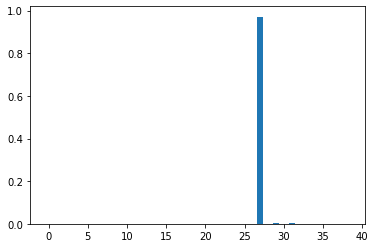

In [28]:
frac = 0.1     #Fraction of dataset to be used in model training

D = pd.DataFrame(Dataset_SOn)                  #Dataframe of the original Dataset
D = D.sample(round((Dataset_SOn.shape[0]*frac)))      #Fraction of Dataset
#D.to_csv('C:/Users/pymnb/Downloads/WAG Case/10/P_all.csv', index=False, header=True)

# define the model
model = RandomForestRegressor()

# fit the model
model.fit(np.array(D)[:,0:No_inputs], np.array(D)[:,No_inputs+1:No_inputs+2])

# get importance
importance = model.feature_importances_

#summarize feature importance
for i,v in enumerate(importance):
    print('Score: '+ str(round(v,5))+', Feature '+str(i)+': '+header[i])
    
#plot feature importance
pyplot.bar([X_sampled for X_sampled in range(len(importance))], importance)
pyplot.show()

## Feature Importance in all well Tier regions

### <u>Perform the Feature importance and plot it</u>

Score: 0.00247, Feature 0: i
Score: 0.00048, Feature 1: j
Score: 0.00425, Feature 2: k
Score: 0.00269, Feature 3: X
Score: 0.00373, Feature 4: Y
Score: 0.01034, Feature 5: Z
Score: 5e-05, Feature 6: Type
Score: 0.0002, Feature 7: D_faults
Score: 0.00234, Feature 8: D_inj1
Score: 0.00026, Feature 9: D_inj2
Score: 0.01554, Feature 10: D_prod1
Score: 0.00036, Feature 11: D_prod2
Score: 0.00026, Feature 12: D_prod3
Score: 0.00442, Feature 13: Ver_H
Score: 0.00473, Feature 14: Str_H
Score: 0.00493, Feature 15: Vol
Score: 0.00021, Feature 16: Angle
Score: 0.00275, Feature 17: NTG
Score: 0.00237, Feature 18: PermX
Score: 0.00634, Feature 19: PermY
Score: 0.00248, Feature 20: PermZ
Score: 0.00718, Feature 21: Porosity
Score: 0.0036, Feature 22: Sat_Table
Score: 0.00658, Feature 23: TransX
Score: 0.00444, Feature 24: TransY
Score: 0.00545, Feature 25: TransZ
Score: 0.16605, Feature 26: Flux_Region
Score: 8e-05, Feature 27: SO_i
Score: 0.0, Feature 28: SG_i
Score: 0.00287, Feature 29: SW_i
Score

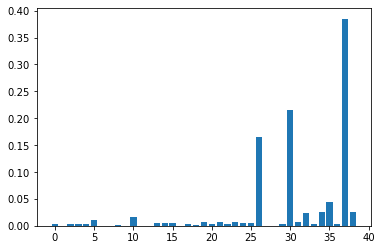

In [41]:
frac = 1     #Fraction of dataset to be used in model training

D = pd.DataFrame(DatasetP2)                  #Dataframe of the original Dataset
D = D.sample(round((DatasetP2.shape[0]*frac)))      #Fraction of Dataset
#D.to_csv('C:/Users/pymnb/Downloads/WAG Case/15/P_250.csv', index=False, header=None)

# define the model
model = RandomForestRegressor()

# fit the model
model.fit(np.array(D)[:,0:No_all], np.array(D)[:,No_all+1:No_all+2])

# get importance
importance = model.feature_importances_

#summarize feature importance
for i,v in enumerate(importance):
    print('Score: '+ str(round(v,5))+', Feature '+str(i)+': '+header[i])
    
#plot feature importance
pyplot.bar([X_sampled for X_sampled in range(len(importance))], importance)
pyplot.show()